In [5]:
import re
import pandas as pd
import bs4
import spacy
import requests
from spacy import displacy

nlp = spacy.load("en_core_web_sm")

from spacy.matcher import Matcher
from spacy.tokens import Span

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm
pd.set_option('display.max_colwidth', 200)
# reading csv
candidate_sentences = pd.read_csv("wiki_sentences_v2.csv")
# exploring data
print(candidate_sentences.shape)
print(candidate_sentences.columns.values)
#print(candidate_sentences['sentence'].sample(5))

(4318, 1)
['sentence']


In [6]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################

  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text

      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text

      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text

      ## chunk 5
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]


In [7]:
entity_pairs = []

for i in tqdm(candidate_sentences["sentence"]):
  entity_pairs.append(get_entities(i))

entity_pairs[10:20]

def get_relation(sent):

  doc = nlp(sent)

  # Matcher class object
  matcher = Matcher(nlp.vocab)

  #define the pattern
  pattern = [{'DEP':'ROOT'},
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},
            {'POS':'ADJ','OP':"?"}]

  matcher.add("matching_1", None, pattern)

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]]

  return(span.text)


100%|██████████| 4318/4318 [00:37<00:00, 116.30it/s]


100%|██████████| 4318/4318 [00:31<00:00, 136.67it/s]


is               370
was              297
released on       87
include           73
are               71
were              71
released          40
's                38
composed by       35
has               31
have              31
became            31
become            29
released in       27
included          26
called            22
produced          22
considered        20
had               20
made              20
been              18
be                18
scheduled         17
used              17
stars             16
directed by       16
written by        15
hired             14
set               14
produced by       14
wrote             14
introduced in     13
went              13
received          13
wanted            12
began in          11
won               11
began             11
features          10
sold              10
gave              10
opened             9
known as           9
produced in        9
used in            9
gives              9
includes           9
directed     

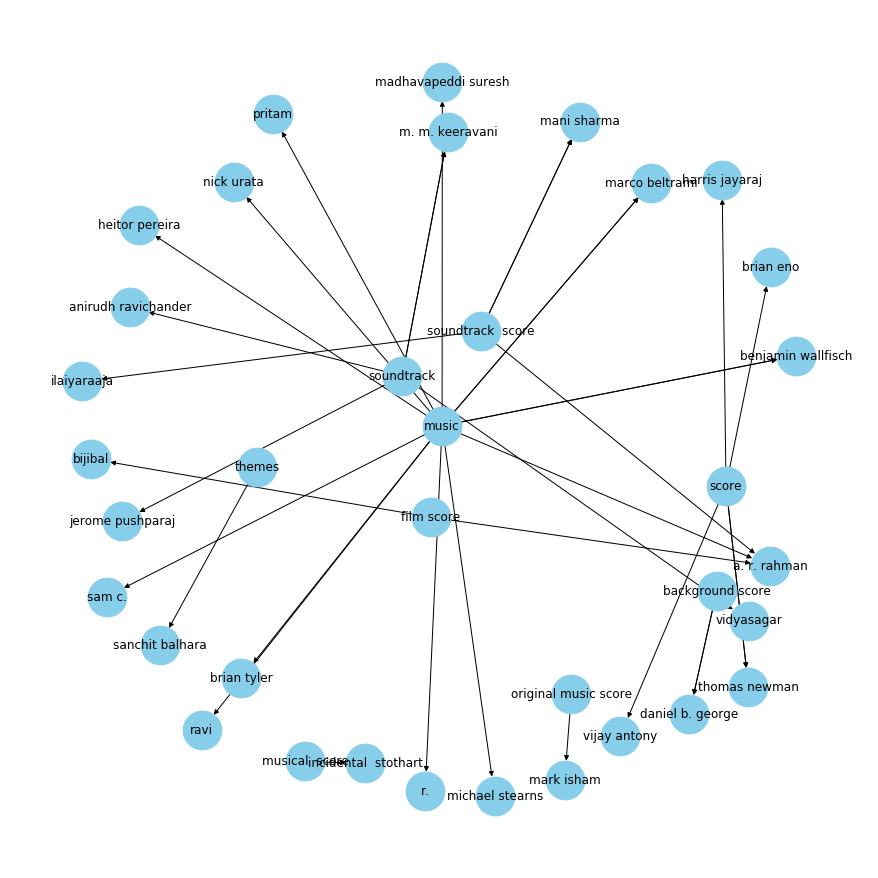

In [11]:
relations = [get_relation(i) for i in tqdm(candidate_sentences['sentence'])]
print(pd.Series(relations).value_counts()[:50])

source = [i[0] for i in entity_pairs]

# extract object
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="composed by"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

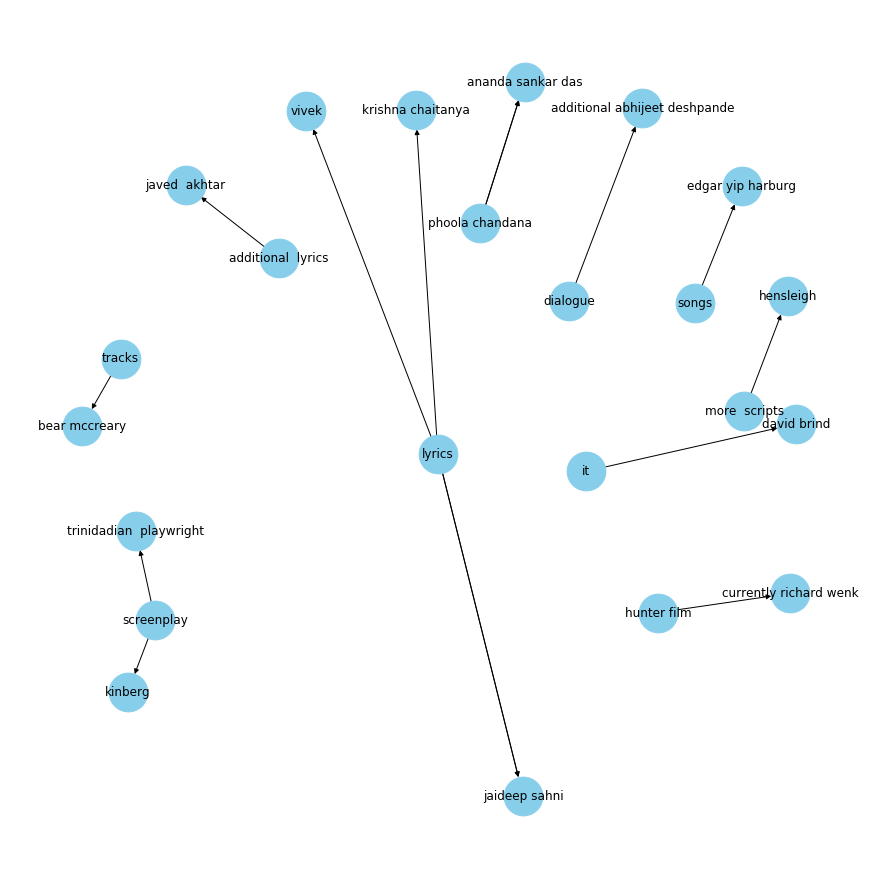

In [12]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="written by"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

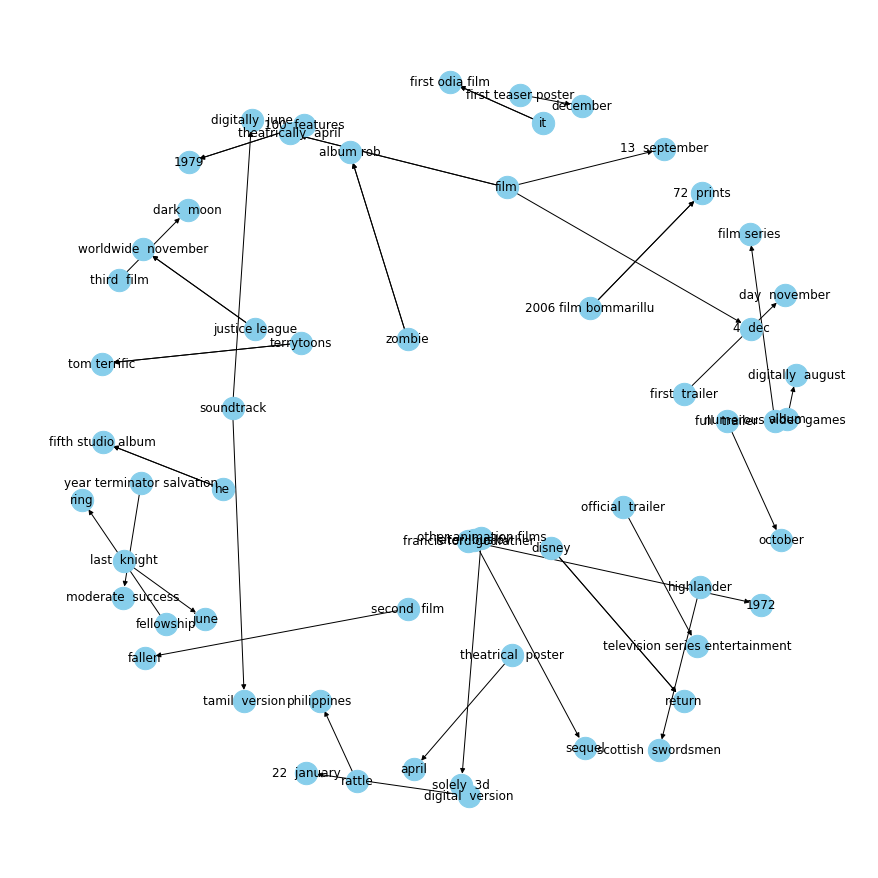

In [14]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="released"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()